# <font style="color: blue; ">  Perturbative estimation of the impact of soliton self-gravity on the core structure </font>

In [1]:
import numpy as np
import time
from scipy.integrate import quad
from scipy import linalg
from scipy import sparse
from scipy import special
from scipy import optimize
from scipy import integrate
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import scipy.special as scp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
from matplotlib.backends.backend_pdf import PdfPages
import scipy.stats as st
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator, FixedLocator)

##  <font style="color: red; "> Definitions </font>

In [2]:
###### Analytic estimate based on Airy function ######

def ffint(eps):
    g= lambda x: np.log(1+x)/x + eps
    if  eps > -0.2:
        xmax = 10000000
    else:
        xmax = 1000000
        eps1 = -0.1
    sol = optimize.brentq(g, 0.00000001, xmax, maxiter=1000)
    return integrate.quad(lambda x: np.sqrt(g(x)), 0, sol, limit=1000)[0]

def wave_func_at_zero(alpha,eps): 
    z_zero = -alpha**(1./3.)*(1.5*ffint(eps))**(2./3.)
#    sol = optimize.brentq(special.airy(z_zero)[0], -0.999, -0.3)
    return special.airy(z_zero)[0]

def solve_eigenvalue1(alpha, epsmin, epsmax): 
    hh = lambda eps: wave_func_at_zero(alpha, eps)
    sol = optimize.brentq(hh, epsmin, epsmax)
    return sol

def get_eigenvalues(alpha, nmax, eps_init):
    evalues=np.zeros(nmax)
    i=0
    eps1 = eps_init
    if  alpha<1e-4:
        delta_eps = 0.00025
        eps1 = -0.1
    elif  alpha>=1.e-4 and alpha<1.e-3:
        delta_eps = 0.001
        eps1 = -0.2
    elif  alpha >= 1.e-3 and alpha<1:
        delta_eps = 0.01
        eps1 = -0.9
    elif alpha >= 1e6 and alpha<1e8:
        delta_eps = 0.002
        eps1 = -0.99999
    elif alpha >= 1e8 and alpha < 1e10:
        delta_eps = 0.0005
        eps1 = -0.99999
    elif alpha >= 1e10 and alpha < 1e12:
        delta_eps = 0.0001
        eps1 = -0.99999
    elif alpha >= 1e12 and alpha < 1e15:
        delta_eps = 0.00001
        eps1 = -0.99999
    elif alpha >= 1e15 and alpha < 1e17:
        delta_eps = 0.000001
        eps1 = -0.9999999
    elif alpha >= 1e17 and alpha <= 1e20:
        delta_eps = 0.0000001
        eps1 = -0.9999999
    else:
        delta_eps = 0.01
        
    wf1 = wave_func_at_zero(alpha, eps1) 
    while(i < nmax):
        eps2 = eps1 + delta_eps
        wf2 = wave_func_at_zero(alpha, eps2)
        if wf1*wf2<0.:
            evalues[i]=solve_eigenvalue1(alpha, eps1, eps2)
            i+=1
        eps1 = eps2
        wf1 = wf2
    return evalues

def get_ground_state_eigenvalue(alpha, eps_init):
    return get_eigenvalues(alpha, 1, eps_init)[0]

get_E0 = np.vectorize(get_ground_state_eigenvalue)


###### Approximate expression based on the asymptotic behavior of Airy function ######

## !!!!!  This should be accurate only for a large value of alpha !!!! ##

def get_E0_approx(alpha):
    return -1 + alpha**(-1/3)*(9*np.pi/16)**(2/3)

In [3]:
###################################
## (Un-normalized) wave function ##
###################################

def eigen_function(alpha,eps,x):   ## This is 'un-normalized' wave function
    g= lambda x: np.log(1+x)/x + eps
    x_c = optimize.brentq(g, 1e-7, 100)
    if x>x_c:
        z =   alpha**(1./3.)*(1.5*integrate.quad(lambda y: np.sqrt(-g(y)), x_c, x)[0])**(2./3.)
        wave_func = z**(1./4.)/(-g(x))**(1./4.) * special.airy(z)[0]
    elif x<=x_c:
        z = - alpha**(1./3.)*(1.5*integrate.quad(lambda y: np.sqrt( g(y)), x, x_c)[0])**(2./3.)
        wave_func = (-z)**(1./4.)/(g(x))**(1./4.) * special.airy(z)[0]
    return wave_func

eigen_func = np.vectorize(eigen_function)

#########################################################
## Potential for (ground state) soliton: dimensionless ##
#########################################################

def phi_tilde_soliton(gamma, xc, x):
    func_g = 3465*gamma**5*(x/xc)**10 + 19635*gamma**4*(x/xc)**8 + 45738*gamma**3*(x/xc)**6 \
        + 55638*gamma**2*(x/xc)**4 + 36685*gamma*(x/xc)**2 + 11895 
    pphi = gamma**0.5 * func_g / (1 + gamma*(x/xc)**2)**6 + 3465/(x/xc)*np.arctan(gamma**0.5*x/xc)
    return - pphi * xc**2 / (4 * 53760) / gamma**1.5

#########################################################
## (Normalized) energy shift at leading order: V_{11}  ##
#########################################################

def energy_shift_by_soliton_selfgravity(alpha,eps,x_core):
    if alpha <= 2.:
        xmin = 1.e-3
        xmax = 1.e2        
    elif 2. < alpha <= 1.e3:
        xmin = 1.e-4
        xmax = 1.e1
    elif 1.e3 < alpha <= 1.e6:
        xmin = 1.e-5
        xmax = 1.
    elif 1.e6 < alpha <=1.e10:
        xmin = 1.e-6
        xmax = 1.e-1
    elif 1.e10 < alpha:
        xmin = 1.e-7
        xmax = 1.e-2        
    num    = integrate.quad(lambda y: (eigen_function(alpha,eps,y)*phi_tilde_soliton(0.091, x_core, y)*eigen_function(alpha,eps,y)), xmin, xmax)
    denom  = integrate.quad(lambda y: (eigen_function(alpha,eps,y)*eigen_function(alpha,eps,y)), xmin, xmax)
    return num[0]/denom[0]

##########################################################################################
## Fractional energy shift in the case of rho_c/rho_s=1 : V_{11}/ epsilon_1^{(0)}/alpha ##
##########################################################################################
#
# Output value is the one normalized by (rho_c/rho_s)

def frac_energy_shift_ground_state(alpha):   # fractional energy shift : delta E_1 / E_1
    eps1 = get_ground_state_eigenvalue(alpha, -0.9999)
    xc = 0.65 * np.sqrt(6/ (alpha*(1+eps1)))
    return energy_shift_by_soliton_selfgravity(alpha, eps1, xc) / eps1

dE1_over_E1 = np.vectorize(frac_energy_shift_ground_state)


##  <font style="color: red; "> Plotting the ratio of soliton core size $\mathcal{R}$ as a function of $\alpha$ </font>

### Result: Left panel of Fig. 10

In [4]:
zz=0
alp = np.logspace(np.log10(0.1),np.log10(1e5), num=80)
E1           = get_E0(alp,-0.9999)
x_c          = 0.65 * np.sqrt( 6 / ( alp * (1 + E1) ) )
integ        = abs(E1)  * dE1_over_E1(alp) / (x_c**2 / 14 / 0.0901)
ratio_core_radius        = np.sqrt(1 / ( 1 + 1.72944*(1 - integ) ) ) 

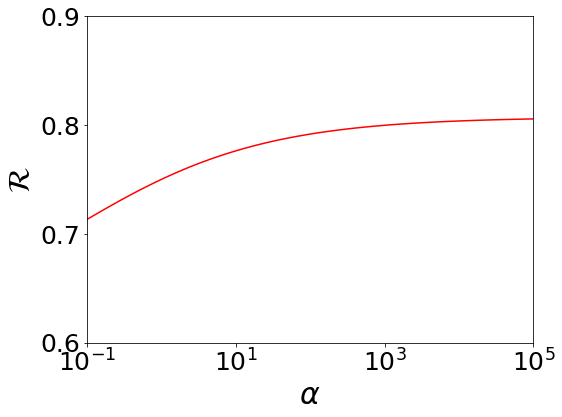

In [6]:
cmg = plt.get_cmap("Greens")
cmb = plt.get_cmap("Blues")

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.set_xscale("log")
ax.set_yscale("linear")
ax.set_ylim(0.6,0.9)
ax.set_xlim(0.1,1e5)
ax.set_xlabel("$\\alpha$",fontsize=30)
ax.set_ylabel("$\\mathcal{R}$",fontsize=30)
ax.plot(alp, ratio_core_radius, "-", color="red")
#   ax.plot(ccvir, rr2[i], ":", color=cmb(1-0.1*i))

ax.tick_params(labelsize=25)
#ax.legend(shadow=True,loc='lower left',borderaxespad=0.5,fontsize=18,handletextpad=0.5,handlelength= 1.2)
# 
## Output to PDF file
# pp = PdfPages('/Users/ataruya/Files/Lin/work_space/FDM/draft/Figs/ratio_core_radius_alpha.pdf')
# pp.savefig(fig, bbox_inches='tight')
# pp.close()

##  <font style="color: red; "> Plotting the ratio of soliton core size $\mathcal{R}$ in the $(M_{\rm h}, \,c_{\rm vir})$-plane </font>

### Cosmological parameters and cosmology-dependent quantities

In [7]:
zred = 0.0
mphi = 8e-23

hubble = 0.677
Omegam0 = 0.276
Omegab0 = 0.02258/hubble**2
OmegaCDM0 = Omegam0 - Omegab0
OmegaL0 = 1-Omegam0

rho_crit0 = 2.77536627e11   #  in units of h^2 M_sun/ Mpc^3
rho_m0 = Omegam0*rho_crit0

def Omegam(zred):
    return (1+zred)**3 * Omegam0/((1+zred)**3 * Omegam0 + OmegaL0)

def fcvir(cvir):
    return 1/(cvir*(np.log(1+cvir)-cvir/(1+cvir)))

def Deltavir(zred):
    result = 18*np.pi**2 + 82*(Omegam(zred)-1)-39*(Omegam(zred)-1)**2
    result = result/Omegam(zred)
    return result

### Parameter $\alpha$ given as a function of redshift, FDM & halo masses, and concentration parameter

In [8]:
def alpha(zred,mphi,mass,cvir):
    result = 7.213e4 * (mphi/1e-21)**2 * (mass/1e9)**(4.0/3.0) * (Deltavir(zred)/200)**(-1.0/3.0) * (Omegam0*hubble**2/0.147)**(-1.0/3.0) * fcvir(cvir)/(1+zred)
    return result

### Computing the ratio of core radius in the $(M_{\rm h}, \,c_{\rm vir})$-plane

In [9]:
vmin = 1.e-1
vmax = 3.e2

print("This will take several minutes. If you have already created the data, ")
print("just skip this cell, and load the data below. Run ? y or n ")
str_test = input()

if(str_test=="y"):
    start = time.time()

    directory = "/Users/ataruya/Files/Lin/work_space/FDM/data_JupyterNB/"  ## Change the save directory appropriately 
    result_rc_x = np.array([])
    result_rc_y = np.array([])
    result_rc_z = np.array([])

    N_rand=40
    rand_Mvir = np.logspace(8,13,N_rand)
    rand_cvir = np.logspace(np.log10(vmin),np.log10(vmax),N_rand)
    for i in range(len(rand_Mvir)):
        Mvir_here = rand_Mvir[i]
        for j in range(len(rand_cvir)):
            cvir_here = rand_cvir[j]
            alpha_here = alpha(zred,mphi,Mvir_here,cvir_here)
        
            E1    = get_E0(alpha_here,-0.9999)
            x_c   = 0.65 * np.sqrt( 6 / ( alpha_here * (1 + E1) ) )
            integ = abs(E1)  * dE1_over_E1(alpha_here) / (x_c**2 / 14 / 0.0901)
            ratio_core_radius = np.sqrt(1 / ( 1 + 1.72944*(1 - integ) ) )
        
            result_rc_x = np.append(result_rc_x, Mvir_here)
            result_rc_y = np.append(result_rc_y, cvir_here)
            result_rc_z = np.append(result_rc_z, ratio_core_radius)
            
    np.save(directory + "Mvir",result_rc_x)
    np.save(directory + "cvir",result_rc_y)
    np.save(directory + "ratio_core_radius",result_rc_z)
else:
    print("Nothing has done. Thanks !! ")
            

This takes several minutes. If you have already created the data, 
just skip this computation, and load the data below. Run ? y or n 


 y


### Result: right panel of Fig. 10

In [7]:
directory = "/Users/ataruya/Files/Lin/work_space/FDM/data_JupyterNB/" ## This directory should be the same one as indicated in the above cell.
result_rc_x = np.load(directory + "Mvir.npy")
result_rc_y = np.load(directory + "cvir.npy")
result_rc_z = np.load(directory + "ratio_core_radius.npy")

/var/folders/cb/4q5dpz7x27l204yzpcv4984r0000gn/T/ipykernel_5106/4065108813.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(name_x_labels)


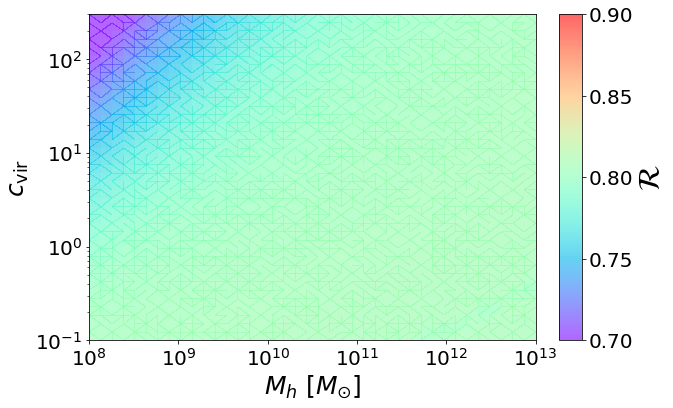

In [11]:
zmin = 0.7
zmax = 0.9


theory_color1 = "blue"
cmap = "rainbow"
fig = plt.figure(figsize=(8,6))
# plt.subplots_adjust(wspace=0.3, hspace=0.6)

##########################################################
##### Impact of soliton self gravity on core radius  #####
##########################################################

ax = fig.add_subplot(1,1,1)

ax.set_xlim(8,13)
ax.set_yscale("log")
#ax.set_ylim(0.2,10)
ax.set_ylim(0.1,300)
# ax.tripcolor(np.log10(result_rc_x), result_rc_y, result_rc_z, cmap=cmap, alpha=0.6,norm = LogNorm())
ax.tripcolor(np.log10(result_rc_x), result_rc_y, result_rc_z, cmap=cmap, alpha=0.6, norm=Normalize(vmin=zmin, vmax=zmax))

ax.set_xlabel("$M_h$ [$M_{\\odot}$]",fontsize=25)
ax.set_ylabel(r"$c_{\rm vir}$",fontsize=25)
#ax.legend(loc="upper right",borderpad=0.5, handlelength=1.5, handletextpad=0.2, fontsize=18)

name_x_labels = ['$10^{8}$','$10^{9}$','$10^{10}$','$10^{11}$','$10^{12}$','$10^{13}$']
ax.set_xticklabels(name_x_labels)
ax.tick_params(axis="x",labelsize=20)
ax.tick_params(axis="y",labelsize=20)


axpos_here = ax.get_position()
cbar_ax = fig.add_axes([axpos_here.x0+axpos_here.width+0.04, axpos_here.y0, 0.04, axpos_here.y0-axpos_here.y0+axpos_here.height])
norm = Normalize(vmin=zmin, vmax=zmax)
mappable = ScalarMappable(cmap=cmap,norm=norm)
cb = plt.colorbar(mappable, cax=cbar_ax, alpha=0.6)
cb.ax.tick_params(labelsize=25)
cb.set_label("$\\mathcal{R}$",fontsize=30)
cb.ax.tick_params(labelsize=20)

## Output to PDF file
# pp = PdfPages('/Users/ataruya/Files/Lin/work_space/FDM/draft/Figs/ratio_core_radius_Mh_cvir.pdf')
# pp.savefig(fig, bbox_inches='tight')
# pp.close()